In [51]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.action_chains import ActionChains
import requests
import bs4
import re
import pandas as pd
import threading
from collections import Counter
import numpy as np
import nltk
import math
import json
import random

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# from geopy import distance

import pickle

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import polyline

from webdriver_manager.chrome import ChromeDriverManager

import time
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib 

!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
fm.fontManager.ttflist += fm.createFontList(['thsarabunnew-webfont.ttf'])
matplotlib.rc('font', family='TH Sarabun New')
fp = matplotlib.font_manager.FontProperties(family='TH Sarabun New',size=13)
fm.fontManager.ttflist += fm.createFontList(['thsarabunnew-webfont.ttf'])



/bin/bash: wget: command not found
[nltk_data] Downloading package stopwords to /Users/mino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mino/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/mino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-51-2cdf7a21d9ae>:58: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  fm.fontManager.ttflist += fm.createFontList(['thsarabunnew-webfont.ttf'])
<ipython-input-51-2cdf7a21d9ae>:61: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  fm.fontManager.ttflist += fm.crea

In [13]:
infodf = pd.read_csv('info.csv',index_col=0)
reviewdf = pd.read_csv('reviews.csv',index_col=0)

In [295]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [296]:
# return word type for lemmatize ( N , V ,...)
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1]
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return {'wordnet' :tag_dict.get(tag[0].upper(), wordnet.NOUN) ,'tag' :tag}


addstopwords= ['plenty','awesome',"there's","i've",'before','try','also','many','good','great','lot','it','it\s','place','much','go','one','lot','floor','like','well','get','make','take',"it’s",'more','less','need','baht','one','two','away','thailand','bkk','bangkok','bang kok','th','per','etc','price','ever',"let's",'thb','ok','left','tell',"can't",'really','never','due','since',"i'd","ban","nearly","non"]

#stopword
stops = (stopwords.words('english'))
for addstopword in addstopwords:
  stops.append(addstopword)
stops = set(stops)


#remove stopwords & punctuation & modalword
def cleanword(word):  
  # print(word)
  word = re.sub(r'\d+', '', word)
  word =remove_emojis(word)
  word =word.replace(",", "").replace(".", "").replace("(", "").replace(")", "").replace("!", "").replace(" ","").replace("-","").replace('<','').replace('>','').replace('^','').lower()
  # print(word)
  if len(word)<2:
    return
  word =lemmatizer.lemmatize(word, get_wordnet_pos(word)['wordnet']).lower()
    # if len(word)>0 and get_wordnet_pos(word)['tag'] != 'R' and get_wordnet_pos(word)['tag'] != 'V'   :
    #   return lemmatizer.lemmatize(word, get_wordnet_pos(word)['wordnet'])
  # if type
  if word not in stops:
    if  get_wordnet_pos(word)['tag'] != 'MD' :
      # dt = determinant md = modal
  
      return word



#ดึง review ใน reviews มา clean -> แยก เป็น word list ['home','temple,'big']
def extractreview(location):
  reviews=[]
  for review in reviewdf.loc[reviewdf['name']==location]['reviews']:
    # review="I go to park It's went mix!"
    # print(review)
    try:
      words=[]
      wordlist = [cleanword(word) for word in str(review).split(" ") if (cleanword(word))!= None ]
      for word in wordlist:
        words.append(word)
      reviews+= words
    except:
      continue
  return reviews 



In [297]:
reviewdict ={}
# allword=[]
for location in infodf['name'].unique():
    print(infodf[infodf['name']==location].index)
    reviewdict[location]= extractreview(location)

Int64Index([0], dtype='int64')
Int64Index([1], dtype='int64')
Int64Index([2], dtype='int64')
Int64Index([3], dtype='int64')
Int64Index([4], dtype='int64')
Int64Index([5], dtype='int64')
Int64Index([6], dtype='int64')
Int64Index([7], dtype='int64')
Int64Index([8], dtype='int64')
Int64Index([9], dtype='int64')
Int64Index([10], dtype='int64')
Int64Index([11], dtype='int64')
Int64Index([12], dtype='int64')
Int64Index([13], dtype='int64')
Int64Index([14], dtype='int64')
Int64Index([15], dtype='int64')
Int64Index([16], dtype='int64')
Int64Index([17], dtype='int64')
Int64Index([18], dtype='int64')
Int64Index([19], dtype='int64')
Int64Index([20], dtype='int64')
Int64Index([21], dtype='int64')
Int64Index([22], dtype='int64')
Int64Index([23], dtype='int64')
Int64Index([24], dtype='int64')
Int64Index([25], dtype='int64')
Int64Index([26], dtype='int64')
Int64Index([27], dtype='int64')
Int64Index([28], dtype='int64')
Int64Index([29], dtype='int64')
Int64Index([30], dtype='int64')
Int64Index([31], d

In [298]:
lenlist = [len(reviewdict[x]) for x in reviewdict]
avlen = sum(lenlist)/len(lenlist)
lenlist
avlen

3089.1639344262294

In [299]:

def computeReviewTFDict(reviews):
  tfdict ={}
  k=1.2
  b=0.75
  for review in reviews:
    reviewTFDict = {}
    
    for word in reviews[review]:
        
        if word in reviewTFDict:
            reviewTFDict[word] += 1
        else:
            reviewTFDict[word] = 1
    tfdict[review] = reviewTFDict
  # print(tfdict)
  for locationname in tfdict :
    locationtfdict = tfdict[locationname]
    l = len(reviewdict[locationname]) / avlen
    
    for i in locationtfdict:
      tf=locationtfdict[i]
      locationtfdict[i] =  ((k + 1) * tf) / (k * (1.0 - b + (b * l)) + tf)
      # print(locationtfdict)
    tfdict[locationname] = locationtfdict
  return tfdict

In [300]:
def computeCountDict():
   
    countDict = {}
    # Run through each review's tf dictionary and increment countDict's (word, doc) pair
    for location,locationtfdict in tfdict.items():
        for word in locationtfdict:
            if word in countDict:
                countDict[word] += 1
            else:
                countDict[word] = 1
    return countDict

In [301]:
def computeIDFDict():
 
    idfDict = {}
    for word in documentfq:
        idfDict[word] = math.log(len(reviewdf['name'].unique()) / documentfq[word],10)
    return idfDict

In [302]:
def computeReviewTFIDFDict():
  
    reviewTFIDFDict = {}
    #For each word in the review, we multiply its tf and its idf.
    for location in tfdict:
      d={}
      tf =tfdict[location]
      # print(location,tf)
      
      for word in tf:
        d[word] = tf[word] * idfdict[word] 

        
      reviewTFIDFDict[location] = d
    return reviewTFIDFDict

In [303]:
#Stores the review count dictionary
tfdict =computeReviewTFDict(reviewdict)
documentfq = computeCountDict()
#Stores the idf dictionary
idfdict = computeIDFDict()

#Stores the TF-IDF dictionaries
tfidfdict = computeReviewTFIDFDict()



In [54]:
# #### upload
# with open('vectordict.p', 'wb') as fp:
#     pickle.dump(vectordict, fp, protocol=pickle.HIGHEST_PROTOCOL)

# !cp vectordict.p

usage: cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file target_file
       cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file ... target_directory


In [16]:
aaa =list(sorted(sumtfidf.items(), key=lambda item: item[1],reverse=True))

In [4]:
catvectdict.keys()

dict_keys(['establishment natural feature', 'museum point of interest', 'park point of interest', 'museum tourist attraction', 'establishment market', 'art gallery tourist attraction', 'point of interest shopping mall', 'library tourist attraction', 'health local government office', 'tourist attraction zoo', 'establishment point of interest', 'amusement park tourist attraction', 'aquarium point of interest', 'neighborhood route', 'park tourist attraction', 'market point of interest', 'market store', 'amusement park point of interest', 'point of interest premise', 'place of worship point of interest', 'movie theater museum', 'finance museum', 'church place of worship', 'art gallery point of interest', 'hindu temple tourist attraction', 'cafe food', 'cafe restaurant', 'book store store', 'art gallery cafe', 'place of worship premise', 'hindu temple place of worship', 'skyscraper tourist attraction', 'health museum', 'food restaurant', 'point of interest transit station', 'tourist attract

In [12]:

sumtfidf={}
for l , ltfidf in tfidfdict.items():
  # print(ltfidf)
  for word in ltfidf :
    if word in sumtfidf:
      sumtfidf[word] = sumtfidf[word]+ ltfidf[word]
    else:
      sumtfidf[word] = ltfidf[word]

In [7]:
countdict ={}
for k,v in sumtfidf.items():
  for i in range(150):
    if v >=i :
      if str(i) in countdict:
        countdict[str(i)] = countdict[str(i)]+1
      else :
        countdict[str(i)] = 1

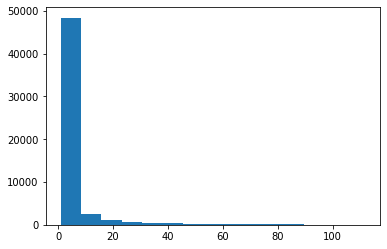

In [284]:
x = [sumtfidf[i] for i in sumtfidf]
plt.hist(x, bins =15)
plt.show()

In [8]:
finalword = []
for k,v in sumtfidf.items():
  if v >=52 and k not in finalword:
    finalword.append(k)

In [9]:
vectordict={}

for location in tfidfdict:
  vector = [0.0] * len(finalword)
  for i,word in enumerate(finalword):
    if word in tfidfdict[location]:
      vector[i] = tfidfdict[location][word]
  vectordict[location] = vector

In [10]:
len(vectordict['Dream World'])

1200

In [288]:
len(finalword)

1200

In [73]:
with open('catvectdict.p', 'rb') as fp:
    catvectdict = pickle.load(fp)
with open('sumtfidf.p', 'rb') as fp:
    sumtfidf = pickle.load(fp)
with open('tfidfdict.p', 'rb') as fp:
    tfidfdict = pickle.load(fp)
with open('color.p', 'rb') as fp:
    cc = pickle.load(fp)
    
  



In [14]:
cat =[]
for i,r in infodf.iterrows():
    # print(pd.isnull(r['type'+str(2)]))
    ar=[]
    for i in range(1,10):
        t =r['type'+str(i)]
        n =['point_of_interest','establishment','tourist_attraction']
        if (t not in n )and (not pd.isnull(t)):
            ar.append(t.replace('_'," "))
    if len(ar)==0:
        print(i,r['name'])
    # ar = [ .replace('_'," ") for i in range(1,10) if r(['type'+str(i)] not in ) and not pd.isnull(r['type'+str(i)])]
    try:
        cat.append(" ".join(sorted(ar[:2]))) 
    except:
        print( r['type1'])

In [270]:
  
# cc={}
# for i in cat:
#     r = random.random()
#     b = random.random()
#     g = random.random()
#     color = (r, g, b)
#     if i in cc:
#         continue
#     cc[i]=color

[]

In [504]:
  
def catpca ():
    namear =[]
    vecar=[]
    for k,v in catvectdict.items():
        namear.append(k)
        vecar.append(v )
    vectordf = pd.DataFrame(vecar)
    namedf = pd.DataFrame(namear)
    vectorComponents = pca.fit_transform(vectordf)
    pcadf = pd.DataFrame(data = vectorComponents
             , columns = ['1', '2'])
    finaldf =  pd.concat([pcadf,namedf ], axis = 1)
    # 

  
    fig = plt.figure(figsize = (20,20))
    ax = fig.add_subplot(1,1,1) 
    
    for name in namear:
    
        indicesToKeep = finaldf[0] == name
        ax.scatter(finaldf.loc[indicesToKeep, '1']
                    , finaldf.loc[indicesToKeep, '2']
                    , c = np.array([cc[name]])

                    , s = 50)
    lgd =ax.legend([x for x in catvectdict.keys()],loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid()

    fig.savefig('catvec.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
    # files.download('{}withcatvec.pdf'.format(p))
   
    # vectorComponents = pca.fit_transform(vectordf)
    # vectorDf = pd.DataFrame(data = vectorComponents
    #              , columns = ['1', '2'])

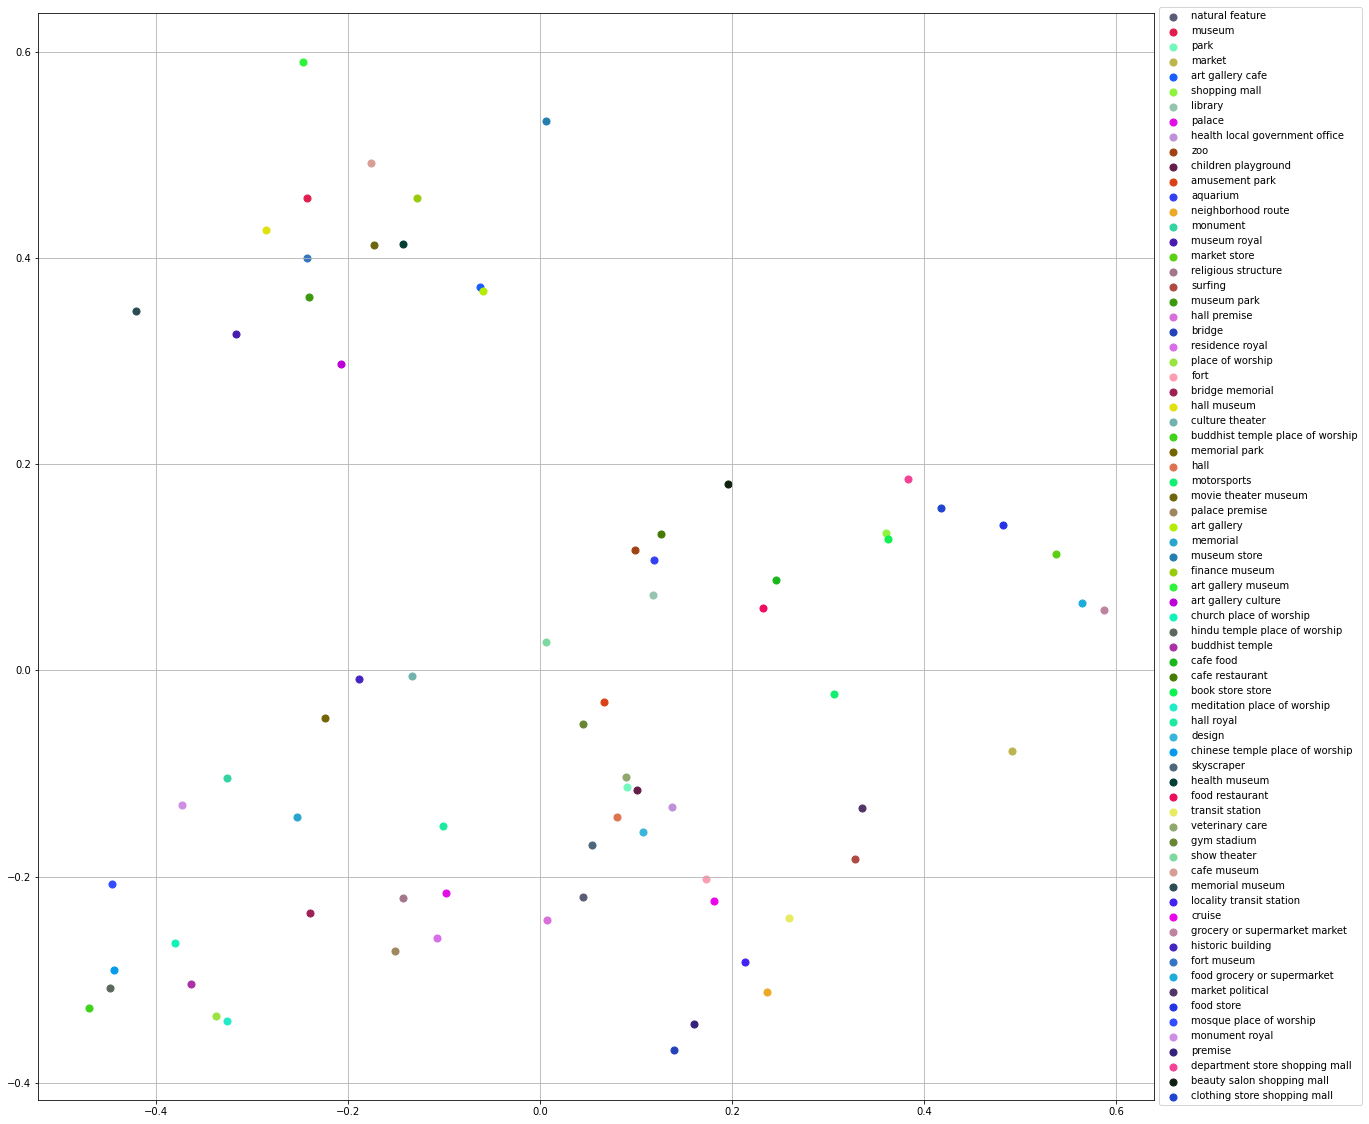

In [505]:
# cc={}
# for i in catvectdict.keys():
#     r = random.random()
#     b = random.random()
#     g = random.random()
#     color = (r, g, b)
#     if i in cc:
#         continue
#     cc[i]=color
catpca()

In [55]:

def reviewpca ():
    namear =[]
    vecar=[]
    for k,v in vectordict.items():
        namear.append(k)
        vecar.append(v )
    vectordf = pd.DataFrame(vecar)
    namedf = pd.DataFrame(namear)
    vectorComponents = pca.fit_transform(vectordf)
    pcadf = pd.DataFrame(data = vectorComponents
             , columns = ['1', '2'])
    finaldf =  pd.concat([pcadf,namedf ], axis = 1)
 

  
    fig = plt.figure(figsize = (20,20))
    ax = fig.add_subplot(1,1,1) 
    
    for name in namear:
        # print(name)
        try :
            ty =infodf[infodf['name']==name]['finaltype'].values[0]
        except:
            print(name)
        # print(ty)
        indicesToKeep = finaldf[0] == name
        ax.scatter(finaldf.loc[indicesToKeep, '1']
                    , finaldf.loc[indicesToKeep, '2']
                    , c = np.array([cc[ty]])

                    , s = 50)
    lgd =ax.legend([ x for x in cc],loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid()

    # fig.savefig('reviewwithoutcatvec.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
    # files.download('{}withcatvec.pdf'.format(p))
   
    # vectorComponents = pca.fit_transform(vectordf)
    # vectorDf = pd.DataFrame(data = vectorComponents
    #              , columns = ['1', '2'])
    return finaldf

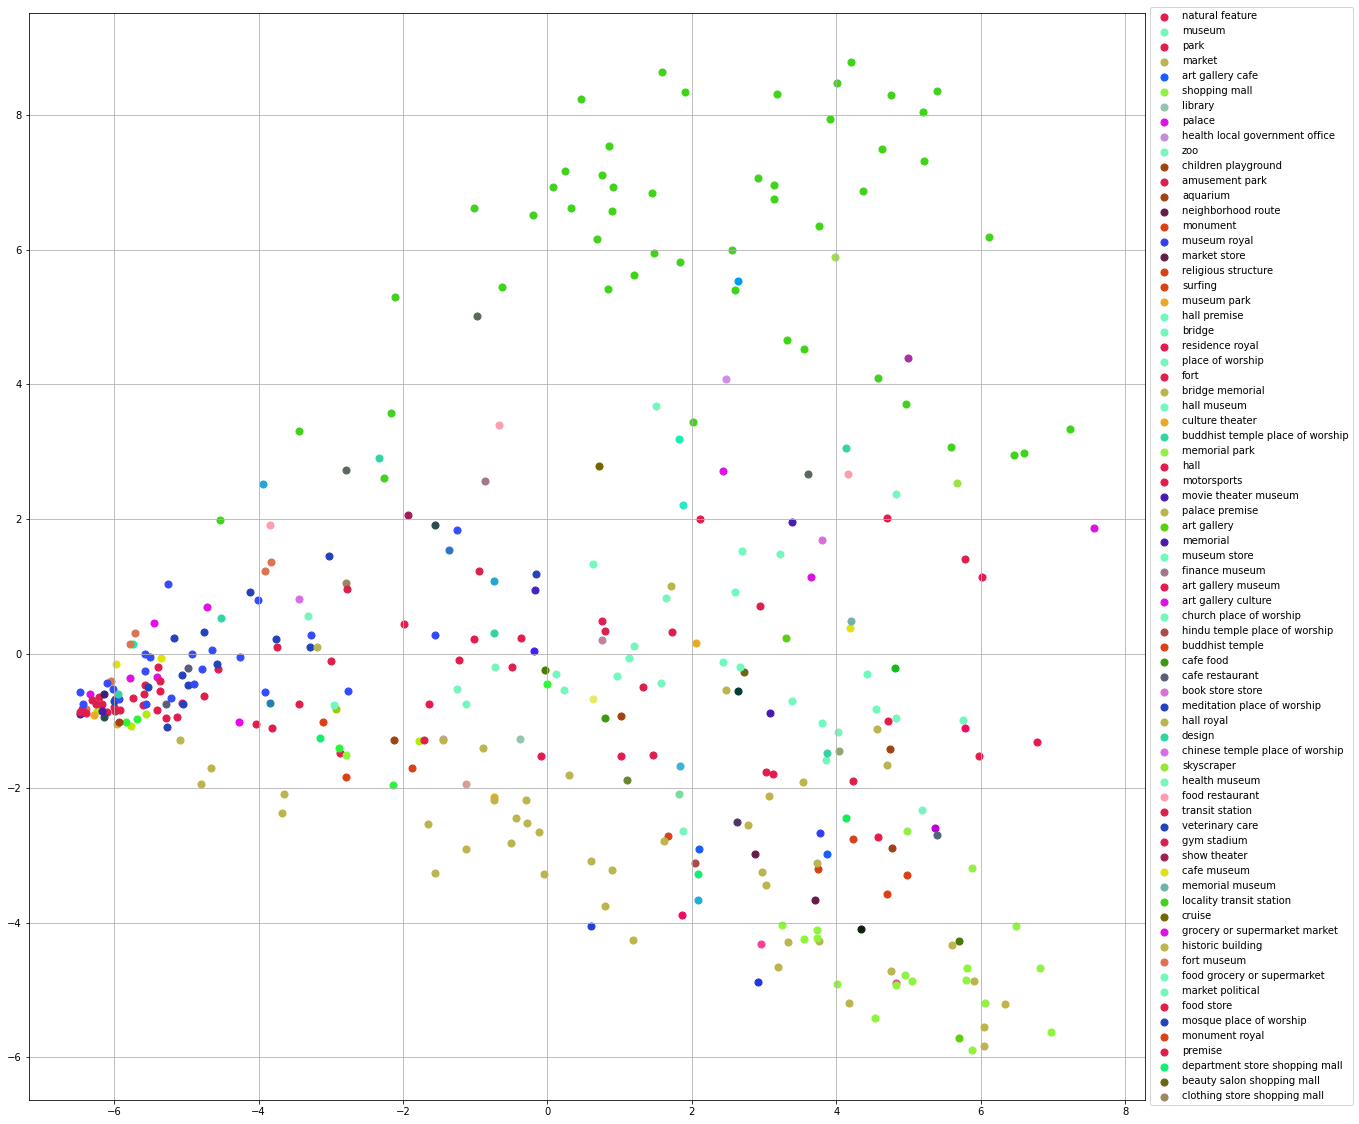

In [56]:

r =reviewpca()

In [507]:

def reviewcatpca ():
    namear =[]
    vecar=[]
    for k,v in vectordict.items():
        namear.append(k)
        ty =infodf[infodf['name']==k]['finaltype'].values[0]
        
        vecar.append( np.concatenate((v, catvectdict[ty]) ))
        # print(len(vecar[0]))
    # for i in range(len(vecar)):
       

    vectordf = pd.DataFrame(vecar)
    namedf = pd.DataFrame(namear)
    vectorComponents = pca.fit_transform(vectordf)
    pcadf = pd.DataFrame(data = vectorComponents
             , columns = ['1', '2'])
    finaldf =  pd.concat([pcadf,namedf ], axis = 1)
 

  
    fig = plt.figure(figsize = (20,20))
    ax = fig.add_subplot(1,1,1) 
    
    for name in namear:
        ty =infodf[infodf['name']==name]['finaltype'].values[0]
    
        indicesToKeep = finaldf[0] == name
        ax.scatter(finaldf.loc[indicesToKeep, '1']
                    , finaldf.loc[indicesToKeep, '2']
                    , c = np.array([cc[ty]])
                    , s = 50)
    lgd =ax.legend([ x for x in cc],loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid()
    # fig.savefig('reviewandcatvec.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
    return finaldf
    # files.download('{}withcatvec.pdf'.format(p))
   
    # vectorComponents = pca.fit_transform(vectordf)
    # vectorDf = pd.DataFrame(data = vectorComponents
    #              , columns = ['1', '2'])

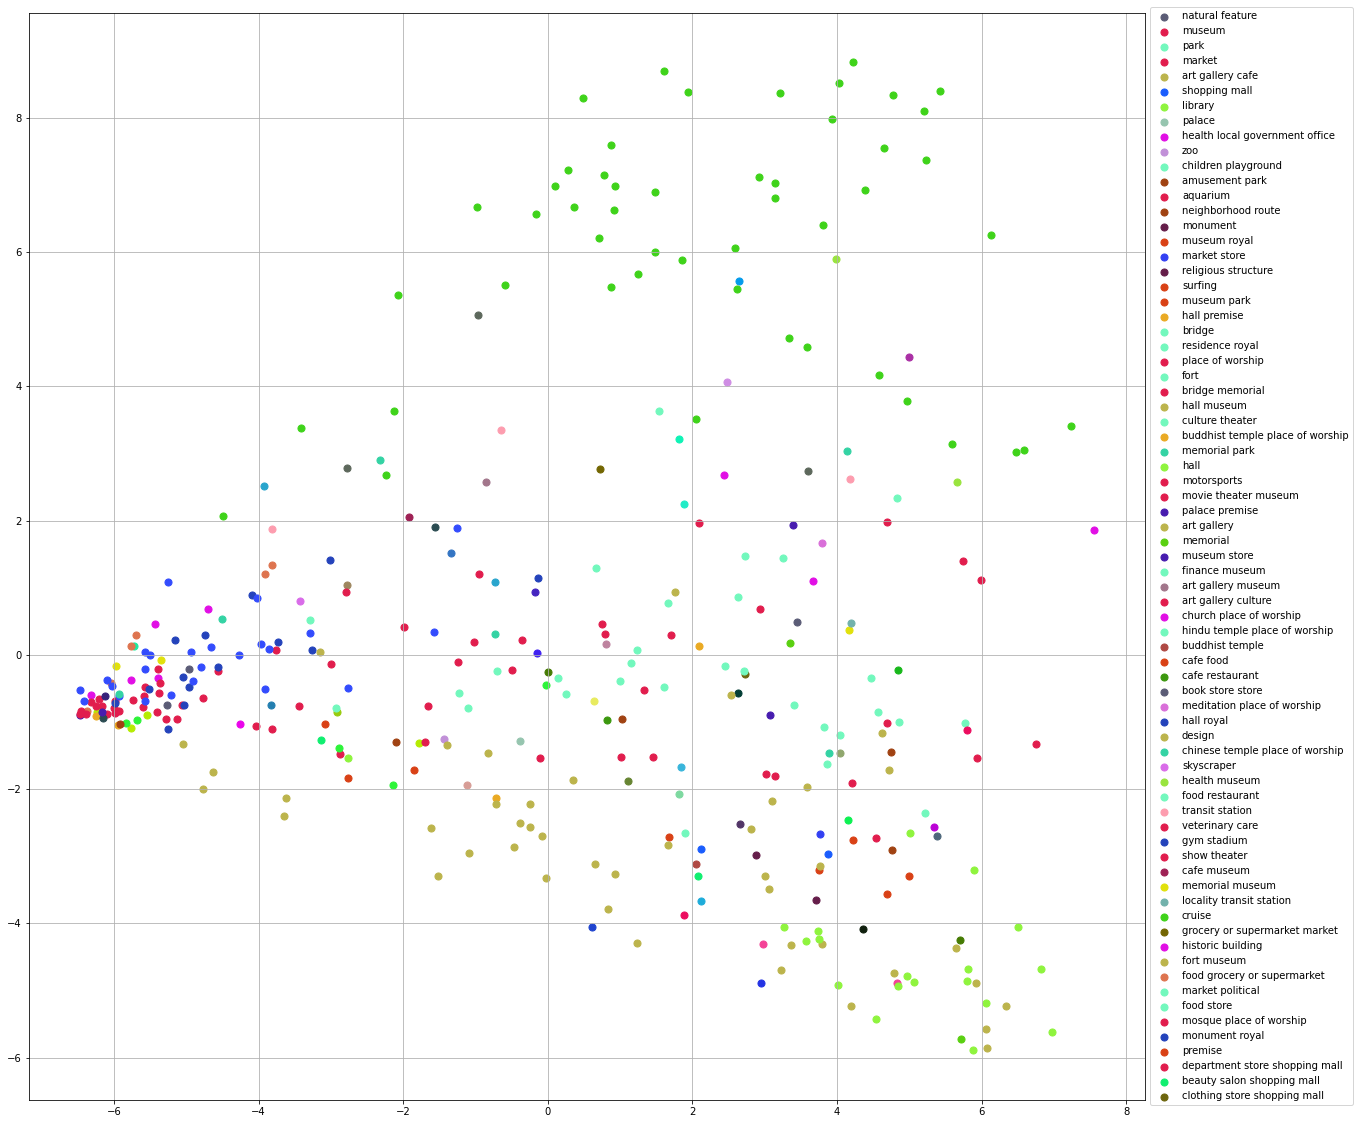

In [508]:
rc =reviewcatpca()

In [498]:
rc

,1,2,0
0,3.441707,0.493159,Ko Kret
1,0.786868,0.310239,MR Kukrit Pramoj House
2,4.852149,-0.993258,Suan Luang Rama IX
3,-1.235713,-0.112557,Kamthieng House Museum
4,-4.632689,-1.739997,Bangkok Farmers' Market (Gateway Ekkamai)
...,...,...,...
361,4.547018,-5.420890,Union Mall
362,4.012258,-4.921241,Silom Complex
363,4.965442,-4.776643,The Mall Bangkapi
364,3.739430,-4.114997,Fortune Town


In [499]:
r

,1,2,0
0,3.439055,0.505916,Ko Kret
1,0.805458,0.327552,MR Kukrit Pramoj House
2,4.851901,-0.960888,Suan Luang Rama IX
3,-1.217838,-0.099332,Kamthieng House Museum
4,-4.645581,-1.696043,Bangkok Farmers' Market (Gateway Ekkamai)
...,...,...,...
361,4.534093,-5.428739,Union Mall
362,3.999121,-4.923170,Silom Complex
363,4.953090,-4.775405,The Mall Bangkapi
364,3.727459,-4.113335,Fortune Town


In [469]:
infodf[infodf['name']=='Dream World']['finaltype'].values[0]

'amusement park'

In [434]:
infodf['finaltype'].value_counts()[:50]

museum                              59
buddhist temple place of worship    50
market                              44
park                                30
mosque place of worship             24
shopping mall                       19
bridge                              14
amusement park                       8
palace                               8
hall                                 6
monument                             6
art gallery museum                   5
zoo                                  5
museum royal                         4
art gallery                          4
neighborhood route                   4
natural feature                      3
hindu temple place of worship        3
hall museum                          3
fort                                 3
cafe restaurant                      2
art gallery cafe                     2
place of worship                     2
memorial museum                      2
market store                         2
memorial                 

In [425]:
for i,r in infodf.iterrows():
    if 'temple' in r['name'].lower() and 'buddhist temple' not in cat[i] :
        # infodf.at[i,'type2']=
        print( i ,r['name']+'\n',r['type1'],r['type2'])

118 Sri Maha Mariamman Temple
 hindu_temple tourist_attraction
128 Hua Lampong Temple, Thai
 place_of_worship point_of_interest
146 Rai Khing temple
 premise place_of_worship
150 Dev Mandir Temple Hindu Samaj Bangkok
 hindu_temple place_of_worship
162 佛光山泰華寺(วัดไท่ฮัว ฝอกวงซัน/Fo Guang Shan Thaihua Temple)
 point_of_interest place_of_worship


In [75]:
a=pd.DataFrame()
for k,v in catvectdict.items():
    a = a.append({'name':k,'vector':v},ignore_index=True)
a

,name,vector
0,natural feature,"[0.10601698, 0.013159463, -0.062780276, -0.046..."
1,museum,"[0.09773827, -0.041645855, -0.03274408, 0.0454..."
2,park,"[0.10246298, 0.010526049, -0.04789236, -0.0022..."
3,market,"[0.117283, -0.016853763, -0.045414973, -0.0621..."
4,art gallery cafe,"[0.08344729, -0.033822354, -0.008275082, 0.029..."
...,...,...
68,monument royal,"[0.09490718, -0.028471485, 0.027600493, 0.0230..."
69,premise,"[0.14152049, 0.04429197, -0.0140375765, 0.0131..."
70,department store shopping mall,"[0.08847935, 0.032861415, 0.004695797, 0.00625..."
71,beauty salon shopping mall,"[0.07790426, 0.03856329, 0.0314518, -0.0119282..."


In [69]:
a.loc[0]['vector'][:10]

[0.3459461510952693,
 0.56638105750386,
 0.0,
 0.0,
 0.28008638261518853,
 0.0,
 0.23643051901907144,
 0.3444346415481364,
 0.20852912282829672,
 0.27073294656461794]

In [63]:
a= pd.DataFrame(vectordict).T

In [76]:
a.to_csv('catvector.csv')